# Actor-Critic

## 一、引言

本书之前的章节讲解了基于值函数的方法（DQN）和基于策略的方法（REINFORCE），
基于值函数的方法只学习一个价值函数，而基于策略的方法只学习一个策略函数。

那么，一个很自然的问题是，有没有什么方法既学习价值函数，又学习策略函数呢？


答案就是Actor-Critic。Actor-Critic是囊括一系列算法的整体架构，
目前很多高效的前沿算法都属于Actor-Critic算法。
本章接下来将会介绍一种最简单的 Actor-Critic 算法。

需要明确的是，Actor-Critic 算法本质上是基于策略的算法，
因为这一系列算法的目标都是优化一个带参数的策略，
只是会额外学习价值函数，从而帮助策略函数更好地学习。

## 二、Actor-Critic 算法

在REINFORCE 算法中，目标函数的梯度中有一项轨迹回报，用于指导策略的更新。

REINFOCE 算法用蒙特卡洛方法来估计Q(s, a) ，能不能考虑拟合一个值函数来指导策略进行学习呢？
这正是 Actor-Critic 算法所做的。

在策略梯度中，可以把梯度写成下面这个更加一般的形式：

$g = \mathbb{E}\left[ \sum_{t=0}^T \psi_t \nabla_\theta \log \pi_\theta (a_t \mid s_t) \right]$

其中，$\psi_t$ 可以有以下很多种形式。

(1) $\Sigma_{t=0}^T\gamma^tr_t$: 轨迹总回报

(2) $\Sigma_{t'=t}^T\gamma^{t'-t}r_{t'}$: 动作后回报

(3) $\Sigma_{t'=t}^T\gamma^{t'-t}r_{t'}-b(s_t)$: 基准线版本改进

(4) $Q^{\pi_\theta}(s_t, a_t)$: 动作值函数

(5) $A^{\pi_\theta}(s_t, a_t)$: 优势函数

(6) $r_t+\gamma V^{\pi_\theta}(s_{t+1})-V^{\pi_\theta}(s_t)$: 时序差分残差

REINFORCE 通过蒙特卡洛采样方法对策略梯度的估计是无偏的，但是方差非常大。

我们可以用形式（3）引入基线函数（baseline function）$b(s_t)$来减小方差。

此外，我们也可以采用 Actor-Critic 算法估计一个动作价值函数Q，代替蒙特卡洛采样得到的回报，
这便是形式（4）。

这个时候，我们可以把状态价值函数V 作为基线，从函数 Q 减去这个函数V 则得到函数 A ，
即优势函数（advantage function），这便是形式（5）。

更进一步，我们可以利用Q = r + $\gamma$V得到形式（6）。

我们将Actor-Critic分为两个部分：Actor（策略网络）和Critic（价值网络）。

● Actor 要做的是与环境交互，并在 Critic 价值函数的指导下用策略梯度学习一个更好的策略。

● Critic要做的是通过 Actor 与环境交互收集的数据学习一个价值函数，
这个价值函数会用于判断在当前状态什么动作是好的，什么动作不是好的，进而帮助Actor 进行策略更新。

<img src="./media/img.png" style="zoom:60%;">

<img src="./media/img_1.png" style="zoom:60%;">

## 三、代码实现

In [6]:

import gymnasium as gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Hands_on_RL_Note import rl_utils
from Hands_on_RL_Note.chapter9_PG.Policy_Net import PolicyNet

In [7]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device) # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
        lr=critic_lr) # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states) # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())

        # 均方误差损失函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        actor_loss.backward() # 计算策略网络的梯度
        critic_loss.backward() # 计算价值网络的梯度

        self.actor_optimizer.step() # 更新策略网络的参数
        self.critic_optimizer.step() # 更新价值网络的参数

这里使用了与 REINFORCE 类似的策略网络结构作为 Actor，ValueNet 作为 Critic。

在代码中，结构上注意ValueNet的引入，对于更新操作的更新公式，涉及了更多的数学证明，此处留白，日后有空再细作研究

In [9]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s, episode=1000, return=500.000]


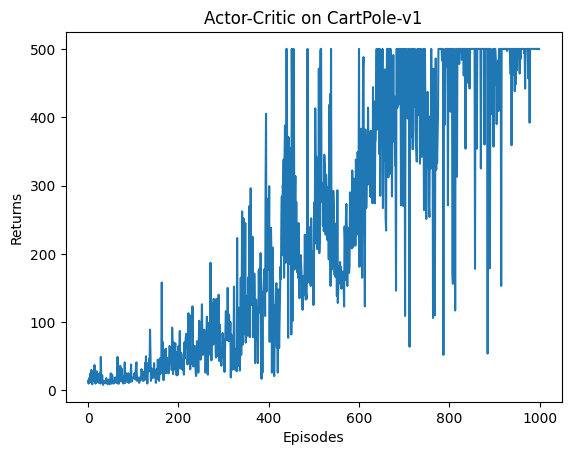

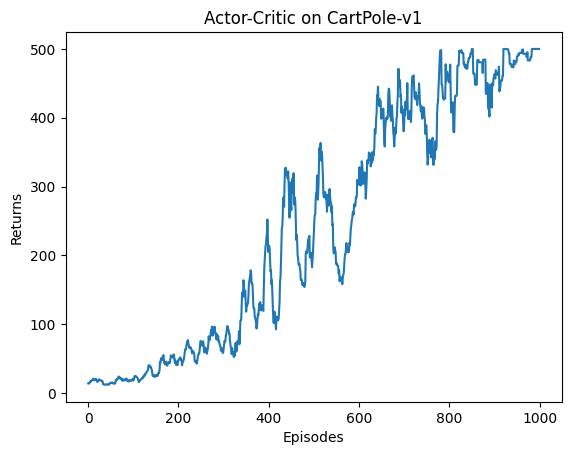

In [10]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list,return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()